In [1]:
import time
import wandb
import random
import numpy as np
import pandas as pd

from attackers import *
from svm_proxies import *
from pympler import asizeof
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
class test_proxy:

    def __init__(self, proxy, attacker, X_val, y_val, log, max_retain = None):
        """
        inputs   : proxy = incremental model object
                   attacker = attacker object
                   X_valid, y_valid = dataset for accuracy metric
                   log = whether to log in wandb
        """
        self.log = log
        self.run = None
        self.proxy = proxy
        self.attacker = attacker
        self.proxy_acc = None
        self.attacker_acc = None
        self.proxy_time = 0.0
        self.max_retain = max_retain

        if hasattr(self.proxy, 'X_retained'):
            self.queries_retained = 0

        # stored dataset
        self.X_val, self.y_val = X_val, y_val

        if self.log:
            self.run = wandb.init('model_security')
        
        else:
            self.proxy_acc_plot = []
            self.attacker_acc_plot = []
            self.acc_diff_plot = []
            self.proxy_times_plot = []
            
            if hasattr(self.proxy, 'X_retained'):
                self.queries_retained_plot = []


    def steal(self, max_queries): 

        for query in range(max_queries):

            x, y = self.attacker.query_fit() # query and improve fit; return the query point
            self.attacker_acc = accuracy_score(self.attacker.predict(self.X_val), self.y_val)

            start = time.time()
            proxy.update(x, y)
            self.proxy_time = time.time() - start
            
            if hasattr(self.proxy, 'X_retained'):
                if isinstance(self.proxy.X_retained, np.ndarray):
                    self.queries_retained = len(self.proxy.X_retained) + len(self.proxy.X_perm)

                    if self.max_retain != None: 
                        if self.queries_retained > self.max_retain:
                            self.proxy.reduce_retained(self.max_retain // 2)

                else:
                    self.queries_retained = query + 1
                    # self.queries_retained = 0

            if query == 0:
                self.proxy_acc = accuracy_score(self.proxy.predict(self.X_val), self.y_val)
            else:
                self.proxy_acc = max(self.proxy_acc, accuracy_score(self.proxy.predict(self.X_val), self.y_val))

            if self.log:
                log_dict = ({
                    "proxy_acc" : self.proxy_acc,
                    "attacker_acc" : self.attacker_acc,
                    'acc_diff' : self.proxy_acc - self.attacker_acc,
                    'proxy_time': self.proxy_time
                })

                if hasattr(self.proxy, 'X_retained'):
                    log_dict['queries_retained'] = self.queries_retained

                wandb.log(log_dict)
            
            else:
                self.proxy_acc_plot.append(self.proxy_acc)
                self.attacker_acc_plot.append(self.attacker_acc)
                self.acc_diff_plot.append(self.proxy_acc - self.attacker_acc)
                self.proxy_times_plot.append(self.proxy_time)

                if hasattr(self.proxy, 'X_retained'):
                    if isinstance(self.proxy.X_retained, np.ndarray):
                        self.queries_retained_plot.append(len(self.proxy.X_retained))
                    else:
                        self.queries_retained_plot.append(query + 1)


        if self.log:
            self.run.finish()
        
        else:
            plt.figure(figsize = (7, 5))
            plt.plot(self.proxy_acc_plot, label = 'proxy_acc')
            plt.plot(self.attacker_acc_plot, label = 'attacker_acc')
            plt.plot(self.acc_diff_plot, label = 'acc_diff')
            plt.yticks([0.1 * i for i in range(10)])
            plt.legend()

            if hasattr(self.proxy, 'X_retained'):
                plt.figure(figsize = (7, 5))
                plt.plot(self.queries_retained_plot, label = 'queries_retained')
                plt.legend()

            plt.figure(figsize = (7, 5))
            plt.plot(self.proxy_times_plot, label = 'time_taken')
            plt.legend()
                

## Linear dataset testing

In [15]:
X, y = datasets.make_blobs(n_samples = 1500, centers = 2, n_features = 2, center_box = (0, 10), random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

true_clf = SVC(kernel = 'linear')
true_clf.fit(X_train, y_train)

# plot_decision_boundary(X_train, y_train, true_clf)
print(accuracy_score(true_clf.predict(X_val), y_val)) # unlikely to be overfit

0.9939393939393939


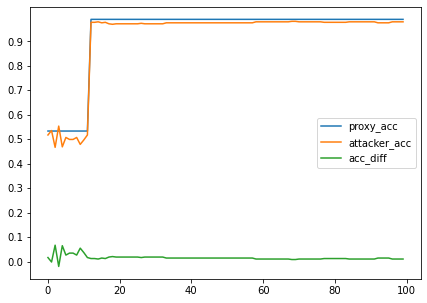

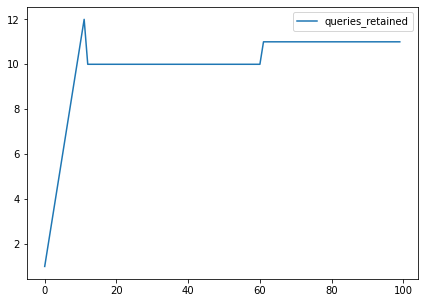

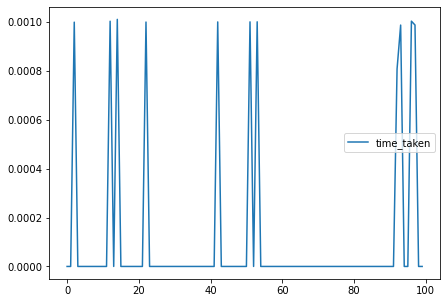

In [18]:
## choose attacker classifier
attacker_clf = LogisticRegression()
# attacker_clf = DecisionTreeClassifier()

## choose incremental proxy
proxy = online_svm_qp(true_clf, 1.0) # 1.0 is a good default

## choose attacker
# attacker = informed_attacker(X, true_clf, attacker_clf)
attacker = benign_user(X, true_clf, attacker_clf, range = 10)

## run test
naive_test = test_proxy(proxy, attacker, X_val, y_val, log = False, max_retain = 100)
naive_test.steal(100)

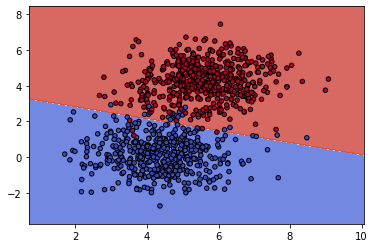

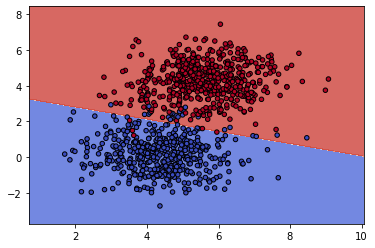

In [19]:
plot_decision_boundary(X_train, y_train, proxy)
plot_decision_boundary(X_train, y_train, attacker)

In [20]:
(proxy.X_retained.shape[0] + len(proxy.X_perm), proxy.X_retained.shape[1])

(30, 2)

## Linear dataset - higher dimensions

In [21]:
X, y = datasets.make_blobs(n_samples = 1500, centers = 2, n_features = 10000, center_box = (0, 10), random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

true_clf = SVC(kernel = 'linear')
true_clf.fit(X_train, y_train)
print(accuracy_score(true_clf.predict(X_val), y_val)) 

1.0


In [ ]:
## choose attacker classifier
attacker_clf = LogisticRegression()
# attacker_clf = DecisionTreeClassifier()

## choose incremental proxy
proxy = online_svm_qp(true_clf, 1e4) # 1.0 is a good default

## choose attacker
# attacker = informed_attacker(X, true_clf, attacker_clf)
attacker = benign_user(X, true_clf, attacker_clf, range = 1e2)

## run test
naive_test = test_proxy(proxy, attacker, X_val, y_val, log = False, max_retain = 50)
naive_test.steal(300)

In [13]:
(proxy.X_retained.shape[0] + len(proxy.X_perm), proxy.X_retained.shape[1])

(27, 10000)

In [14]:
print('size = ', asizeof.asizeof(proxy) / 1e6, 'MB')
print('time = ', sum(naive_test.proxy_times_plot), 'seconds')

size =  4.491904 MB
time =  3.5841917991638184 seconds


## Non linear dataset testing - 1

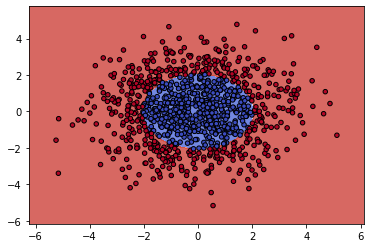

0.997979797979798


In [11]:
X, y = datasets.make_gaussian_quantiles(cov = 3., n_samples = 1500 , n_features = 2, n_classes = 2, random_state = 3)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

true_clf = SVC(kernel = 'poly', degree = 2)
true_clf.fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, true_clf)
print(accuracy_score(true_clf.predict(X_val), y_val))

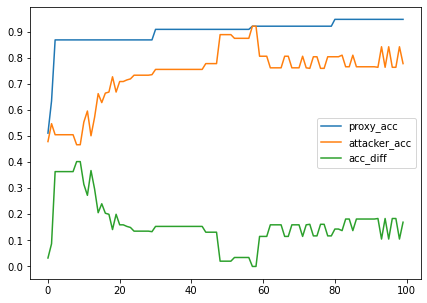

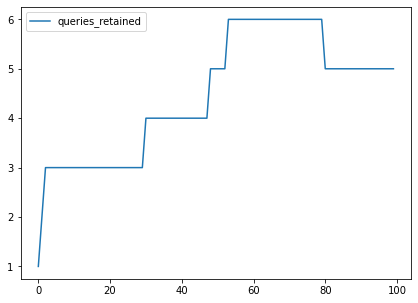

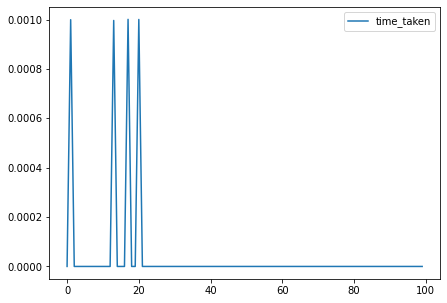

In [12]:
## choose attacker classifier
# attacker_clf = SVC(kernel = 'poly', degree = 2)
attacker_clf = DecisionTreeClassifier(max_depth = 50)

## choose incremental proxy
proxy = online_svm_qp(1.0, degree = 2) # 1.0 is a good default

## choose attacker
# attacker = informed_attacker(X, true_clf, attacker_clf)
attacker = benign_user(X, true_clf, attacker_clf, range = 10)

## run test
naive_test = test_proxy(proxy, attacker, X_val, y_val, log = False, max_retain = 10)
naive_test.steal(100)

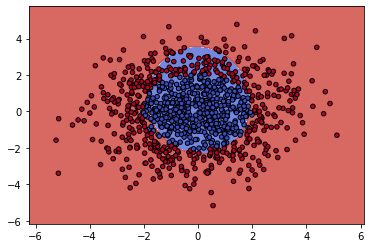

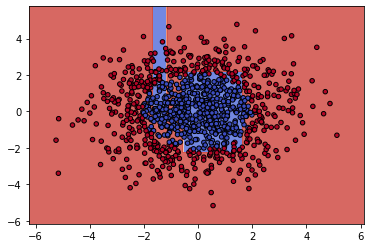

In [13]:
plot_decision_boundary(X_train, y_train, proxy)
plot_decision_boundary(X_train, y_train, attacker)

In [14]:
(proxy.X_retained.shape[0] + len(proxy.X_perm), proxy.X_retained.shape[1])

(5, 5)

## Non linear dataset testing - 2

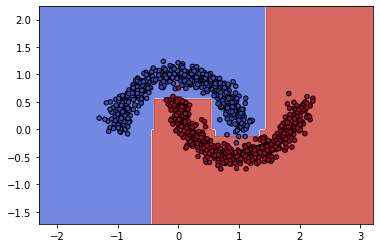

0.9959595959595959


In [15]:
X, y = datasets.make_moons(n_samples = 1500, noise = 0.1, random_state = 26)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.33, random_state = 42)

true_clf = DecisionTreeClassifier(max_depth = 6)
true_clf.fit(X_train, y_train)

plot_decision_boundary(X_train, y_train, true_clf)
print(accuracy_score(true_clf.predict(X_val), y_val))

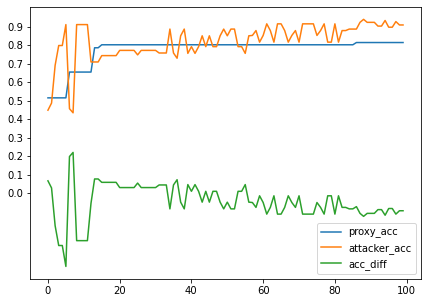

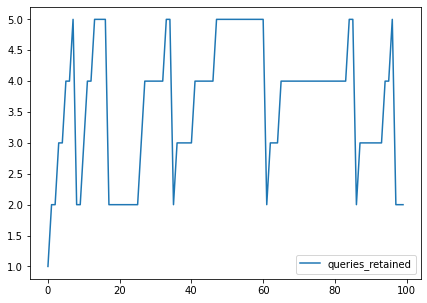

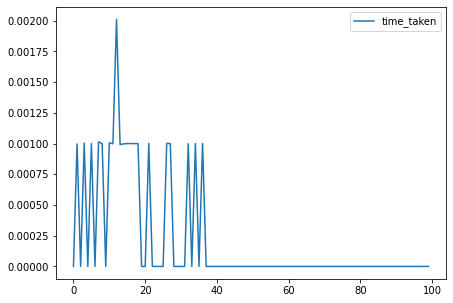

In [16]:
## choose attacker classifier
# attacker_clf = SVC(kernel = 'poly', degree = 3)
attacker_clf = DecisionTreeClassifier(max_depth = 10)

## choose incremental proxy
proxy = online_svm_qp(0.01, degree = 4) # 1.0 is a good default

## choose attacker
# attacker = informed_attacker(X, true_clf, attacker_clf)
attacker = benign_user(X, true_clf, attacker_clf, range = 5)

## run test
naive_test = test_proxy(proxy, attacker, X_val, y_val, log = False, max_retain = 5)
naive_test.steal(100)

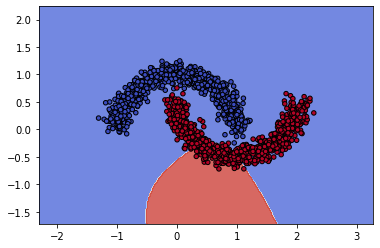

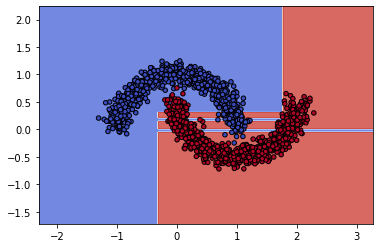

In [17]:
plot_decision_boundary(X, y, proxy)
plot_decision_boundary(X, y, attacker)

In [18]:
(proxy.X_retained.shape[0] + len(proxy.X_perm), proxy.X_retained.shape[1])

(2, 14)